# Rockall Trough transport

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
import src.features.RT_functions as rtf
import src.features.RT_data as rtd
import src.set_paths as sps
import src.features.RT_EOF_functions as rt_eof

import src.features.RT_visualise as rtv

In [2]:
import dask
import datetime
import gsw
import scipy
import scipy.io
import cmocean as cm
import numpy as np
import pandas as pd
import seawater as sw
import scipy.signal as signal
import palettable.colorbrewer as cb
import xarray as xr
from pathlib import Path
from scipy.signal import butter, filtfilt
from xhistogram.xarray import histogram as xhist
%matplotlib inline
from matplotlib import pyplot as plt

### Set in- and output path

In [3]:
date_str_start = '201407'
date_str_end = '202207'
fn_version = 'v1'
script_name = f"0.0_Rockall_Trough_moorings_data_prep_{date_str_start[:-2]}_{date_str_end[:-2]}_v0"
fn_base_grid = "Rockall_Trough_mooring_gridded_TSUV"
fn_base_stack = "Rockall_Trough_mooring_stacked_TSUV"


file_name_in_grid = f"{fn_base_grid}_{date_str_start}_{date_str_end}_{fn_version}.nc"
file_name_in_stack = f"{fn_base_stack}_{date_str_start}_{date_str_end}_{fn_version}.nc"

# output figures
fig_out_path = (sps.local_fig_dir/f"{script_name}")
Path(fig_out_path).mkdir(parents=True, exist_ok=True)

In [4]:
# output data
data_out_path = (sps.local_data_dir/f"{script_name}")
Path(data_out_path).mkdir(parents=True, exist_ok=True)
file_name_out = f"{fn_base_grid}_{date_str_start}_{date_str_end}_{fn_version}.1.nc"

## Parameter Preamble

In [5]:
# Praemble for despike time series after vertical extrapolation to surface
stddy_tol  = 10; # set max velocities range (diff velocity pm stddy_tol)
std_win    = 3.5; # 3.5 * std of the time series (median pm std_win)
nloop    = 5; # max number of despiking repetitions
graphics   = False; #y if plots of despiking on, 'n' if off

## Load Data and prepare for calculations

In [6]:
ds_cruises = rtd.load_cruise_list()

In [7]:
# gridded Rockall Trough mooring data
ds_RT = xr.open_dataset((sps.RT_mooring_data_path/file_name_in_grid))

In [8]:
ds_RT_stacked = xr.open_dataset((sps.RT_mooring_data_path/file_name_in_stack))

In [9]:
# remove nan at beginning and end
ds_RT = ds_RT.where(ds_RT.TG_EAST.sel(PRES=500,method='nearest').notnull().drop_vars('PRES'),drop=True)

## Supplementary data

## Plot preprocess data

In [10]:
def plot_moored_obs(ds_RT,moor,var,ds_RT_stacked,savefig=False):
    ds_cruises = rtd.load_cruise_list()
    fig,axs = plt.subplots(2,1,figsize=[16,8],sharex=True)

    if var=='velocity':
        if moor=='EB1':
            ax = axs[0]
            ds_RT.U_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[1]
            ds_RT.V_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            for ax in axs:
                ds_RT_stacked.PS_EAST_1_UV.plot.line('k',ax=ax,x='TIME',hue='ZS_EAST_1_UV',
                                                     add_legend=False,lw=0.5)

        elif moor=='WB1':
            ax = axs[0]
            ds_RT.U_WEST_1.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[1]
            ds_RT.V_WEST_1.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            for ax in axs:
                ds_RT_stacked.PS_WEST_1_UV.plot.line('k',ax=ax,x='TIME',hue='ZS_WEST_1_UV',
                                                     add_legend=False,lw=0.5)

        elif moor=='WB2':
            ax = axs[0]
            ds_RT.U_WEST_2.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[1]
            ds_RT.V_WEST_2.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            for ax in axs:
                ds_RT_stacked.PS_WEST_2_UV.plot.line('k',ax=ax,x='TIME',hue='ZS_WEST_2_UV',
                                                     add_legend=False,lw=0.5)
    
    elif var=='hydrography':
        sigma_contours = [27.2,27.5, 27.7]
        # manual_locations = [(-12,100),(-12,900),(-12,1250)]
        if moor=='EB1':
            sigma = gsw.sigma0(ds_RT.SG_EAST, ds_RT.TG_EAST)
            ax = axs[0]
            ds_RT.TG_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.thermal)
            CS = sigma.plot.contour(ax=ax,x='TIME',levels=sigma_contours,yincrease=False,colors='w',linewidths =0.5)
            ax.clabel(CS) #,manual=manual_locations)
            ax = axs[1]
            ds_RT.SG_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.haline)
            CS = sigma.plot.contour(ax=ax,x='TIME',levels=sigma_contours,yincrease=False,colors='w',linewidths =0.5)
            for ax in axs:
                ds_RT_stacked.PS_EAST_TS.plot.line('k',ax=ax,x='TIME',hue='ZS_EAST_TS',
                                                   add_legend=False,lw=0.5)
        elif moor=='WB1':
            ax = axs[0]
            sigma = gsw.sigma0(ds_RT.SG_WEST, ds_RT.TG_WEST)
            ds_RT.TG_WEST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.thermal)
            CS = sigma.plot.contour(ax=ax,x='TIME',levels=sigma_contours,yincrease=False,colors='w',linewidths =0.5)
            ax = axs[1]
            ds_RT.SG_WEST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.haline)
            CS = sigma.plot.contour(ax=ax,x='TIME',levels=sigma_contours,yincrease=False,colors='w',linewidths =0.5)
            for ax in axs:
                ds_RT_stacked.PS_WEST_TS.plot.line('k',ax=ax,x='TIME',hue='ZS_WEST_TS',
                                                   add_legend=False,lw=0.5)
        

    for ax in axs:
        ax.vlines(ds_cruises.TIME,0, 1,transform=ax.get_xaxis_transform(),
                  color='k',linestyle='--')
        ax.set_xlabel('')
        ax.grid()

    for i,text in enumerate(ds_cruises):
        axs[0].annotate(text.values, xy=(ds_cruises[i].TIME,-5),va='bottom')

    plt.tight_layout()
    
    if savefig:
        outfig = (fig_out_path/f'RT_{moor}_{var}_{date_str_start}_{date_str_end}.png')
        print(f'Figure saved as {outfig}')
        fig.savefig(outfig,bbox_inches='tight')

# EB1

In [11]:
plot_moored_obs(ds_RT,'EB1','hydrography',ds_RT_stacked,savefig=True)
plot_moored_obs(ds_RT,'EB1','velocity',ds_RT_stacked,savefig=True)

Figure saved as C:\Users\sa07kb\Projects\Rockall_Trough_Transports\figures\0.0_Rockall_Trough_moorings_data_prep_2014_2022_v0\RT_EB1_hydrography_201407_202207.png
Figure saved as C:\Users\sa07kb\Projects\Rockall_Trough_Transports\figures\0.0_Rockall_Trough_moorings_data_prep_2014_2022_v0\RT_EB1_velocity_201407_202207.png


# WB1

Figure saved as C:\Users\sa07kb\Projects\Rockall_Trough_Transports\figures\0.0_Rockall_Trough_moorings_data_prep_2014_2022_v0\RT_WB1_hydrography_201407_202207.png
Figure saved as C:\Users\sa07kb\Projects\Rockall_Trough_Transports\figures\0.0_Rockall_Trough_moorings_data_prep_2014_2022_v0\RT_WB1_velocity_201407_202207.png


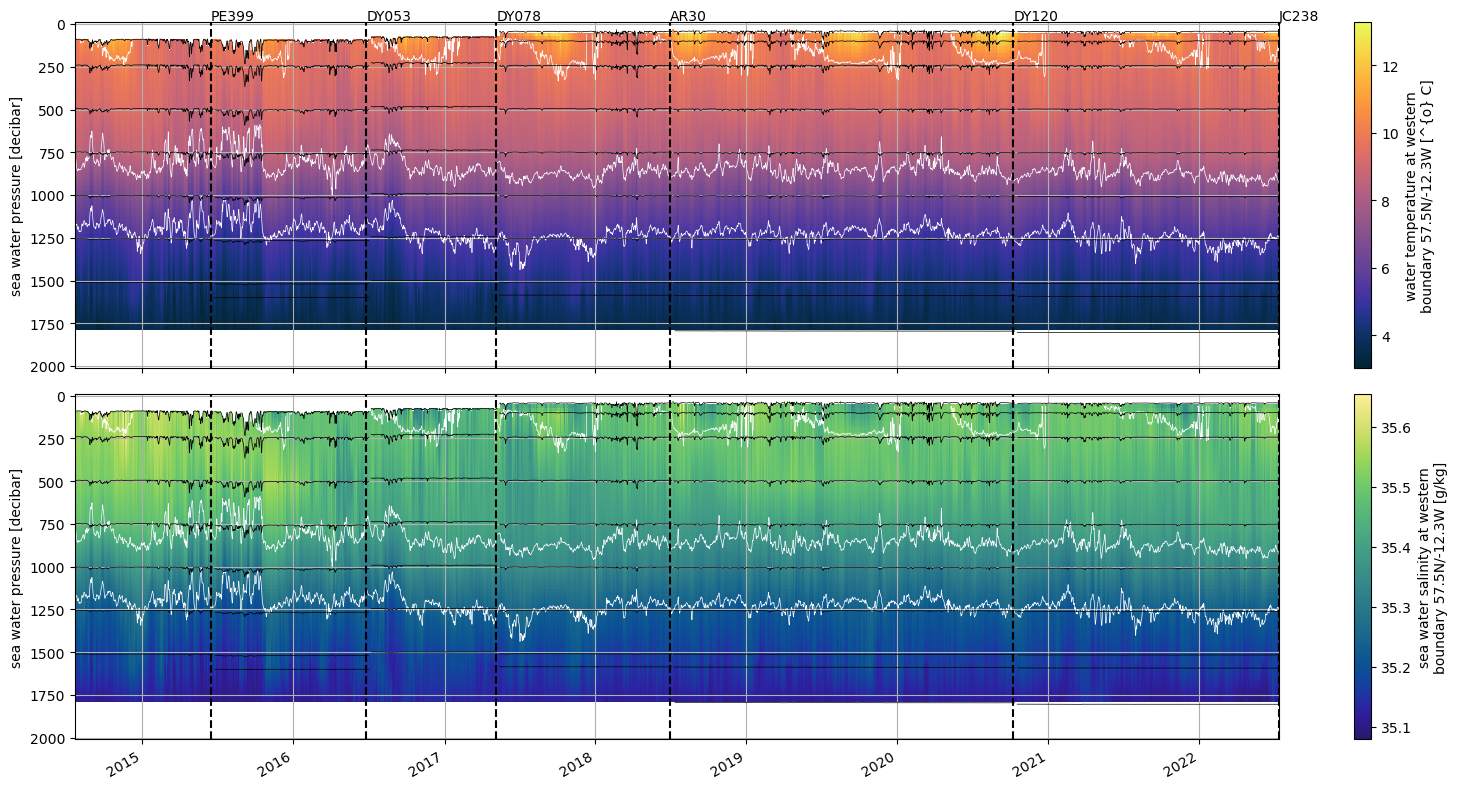

In [12]:
plot_moored_obs(ds_RT,'WB1','hydrography',ds_RT_stacked,savefig=True)
plot_moored_obs(ds_RT,'WB1','velocity',ds_RT_stacked,savefig=True)

# WB2

Figure saved as C:\Users\sa07kb\Projects\Rockall_Trough_Transports\figures\0.0_Rockall_Trough_moorings_data_prep_2014_2022_v0\RT_WB2_velocity_201407_202207.png


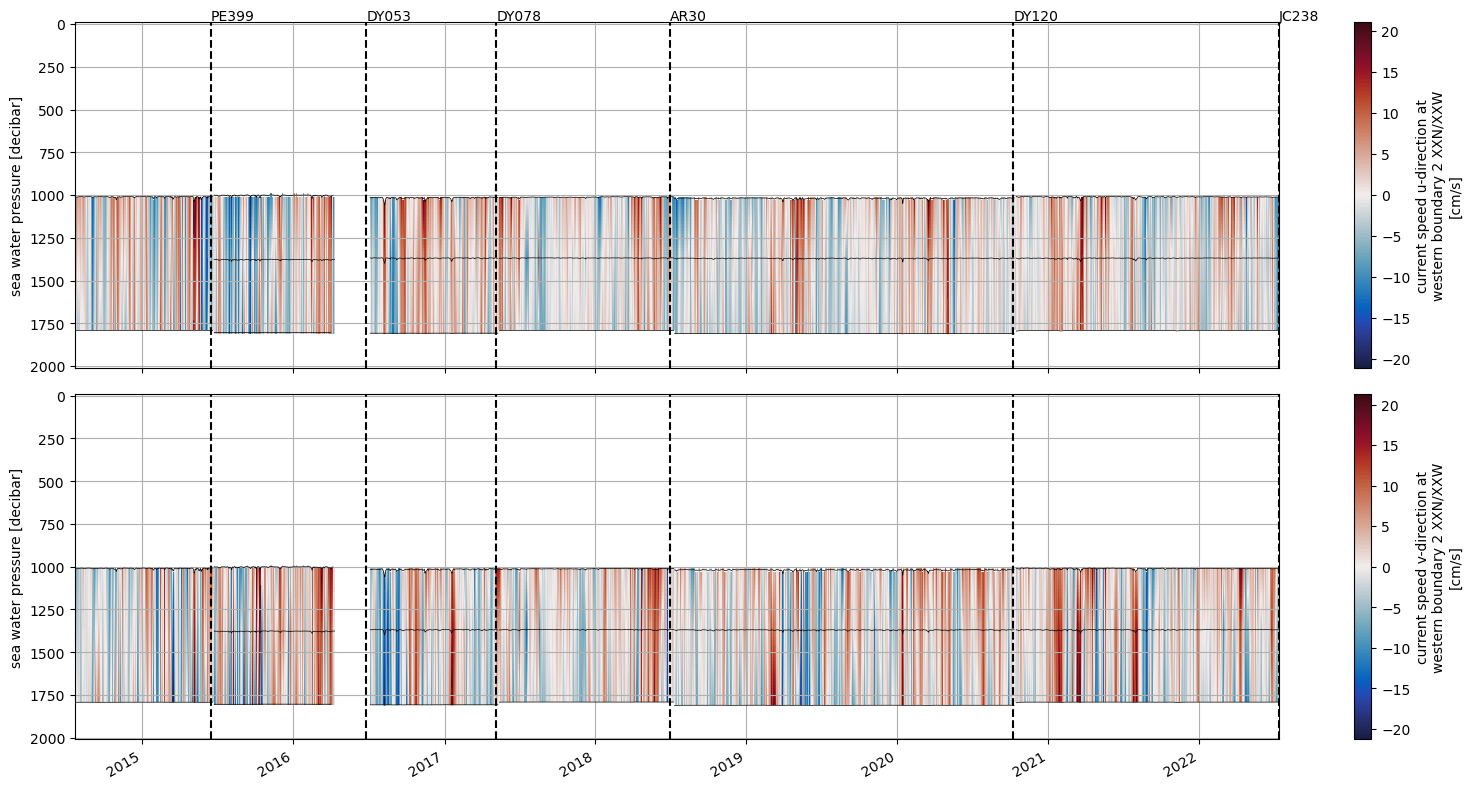

In [13]:
plot_moored_obs(ds_RT,'WB2','velocity',ds_RT_stacked,savefig=True)

## Statistics for gap filling used to created merged product
add ten day lowpass filter

17.108585 10.064220428466797
16.774845 9.884049415588379
16.774845530509065 9.884051953739563
x,y: 0.9511371027479415
RME x, y = 2.4182984828948975
y,y_pred: 0.9511369143202995
RME y, y_pred = 2.3693628377117224


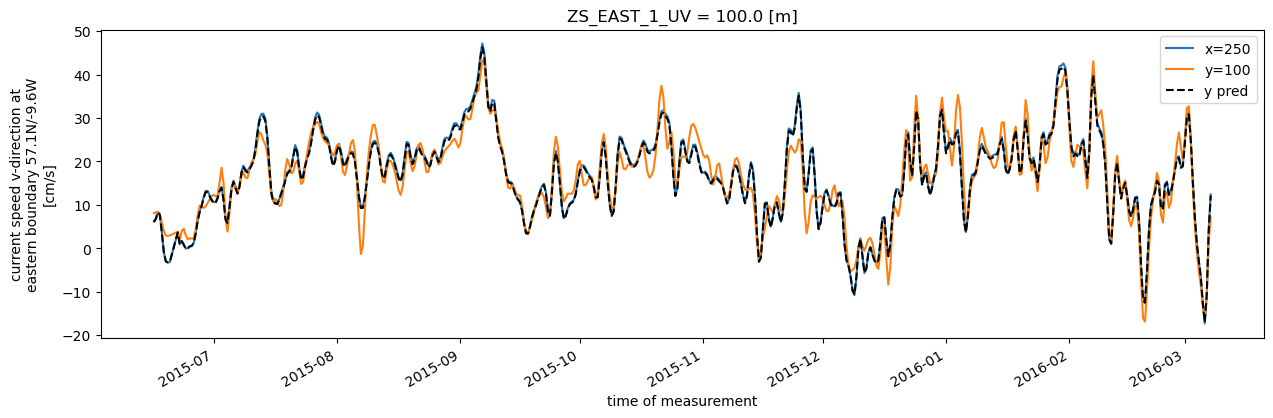

In [14]:
px = 250
py = 100
day_cutoff = 5
period = ds_cruises.TIME[1:3].values
rtf.plot_correlation_stacked(ds_RT_stacked,px,py,period)

In [15]:
px = 500
py = 250
day_cutoff = 5
period = ds_cruises.TIME[1:3].values
rtf.plot_correlation_stacked(ds_RT_stacked,px,py,period)

13.669984 9.530810356140137
16.070107 10.515045166015625
16.070107208709977 10.515044917716413
x,y: 0.9605958678417066
RME x, y = 3.03613543510437
y,y_pred: 0.9605959044939341
RME y, y_pred = 2.2543500490614266


In [16]:
px = 1000
py = 500
day_cutoff = 5
period = ds_cruises.TIME[1:3].values
rtf.plot_correlation_stacked(ds_RT_stacked,px,py,period)

5.906961 6.300337314605713
13.669984 9.530810356140137
13.669984082761617 9.530811290549046
x,y: 0.7916085846340736
RME x, y = 8.324482917785645
y,y_pred: 0.7916085658459628
RME y, y_pred = 4.749921583547034


In [17]:
px = 1350
py = 1785
day_cutoff = 5
period = ds_cruises.TIME[[4,5]].values
rtf.plot_correlation_stacked(ds_RT_stacked,px,py,period)

0.57286114 4.054640769958496
1.231353 4.0731587409973145
1.2313529435715047 4.073158822174876
x,y: 0.6054088214082171
RME x, y = 2.9182889461517334
y,y_pred: 0.6054087759010284
RME y, y_pred = 2.8821400198292557


# Linear extrapolation of upper values

23 exceeds max threshold
Loop number 1
151 spikes found
Loop number 2
150 spikes found
Loop number 3
130 spikes found
Loop number 4
97 spikes found
Loop number 5
9 spikes found
402 exceeds max threshold
Loop number 1
89 spikes found
Loop number 2
36 spikes found
Loop number 3
19 spikes found
Loop number 4
11 spikes found
Loop number 5
5 spikes found


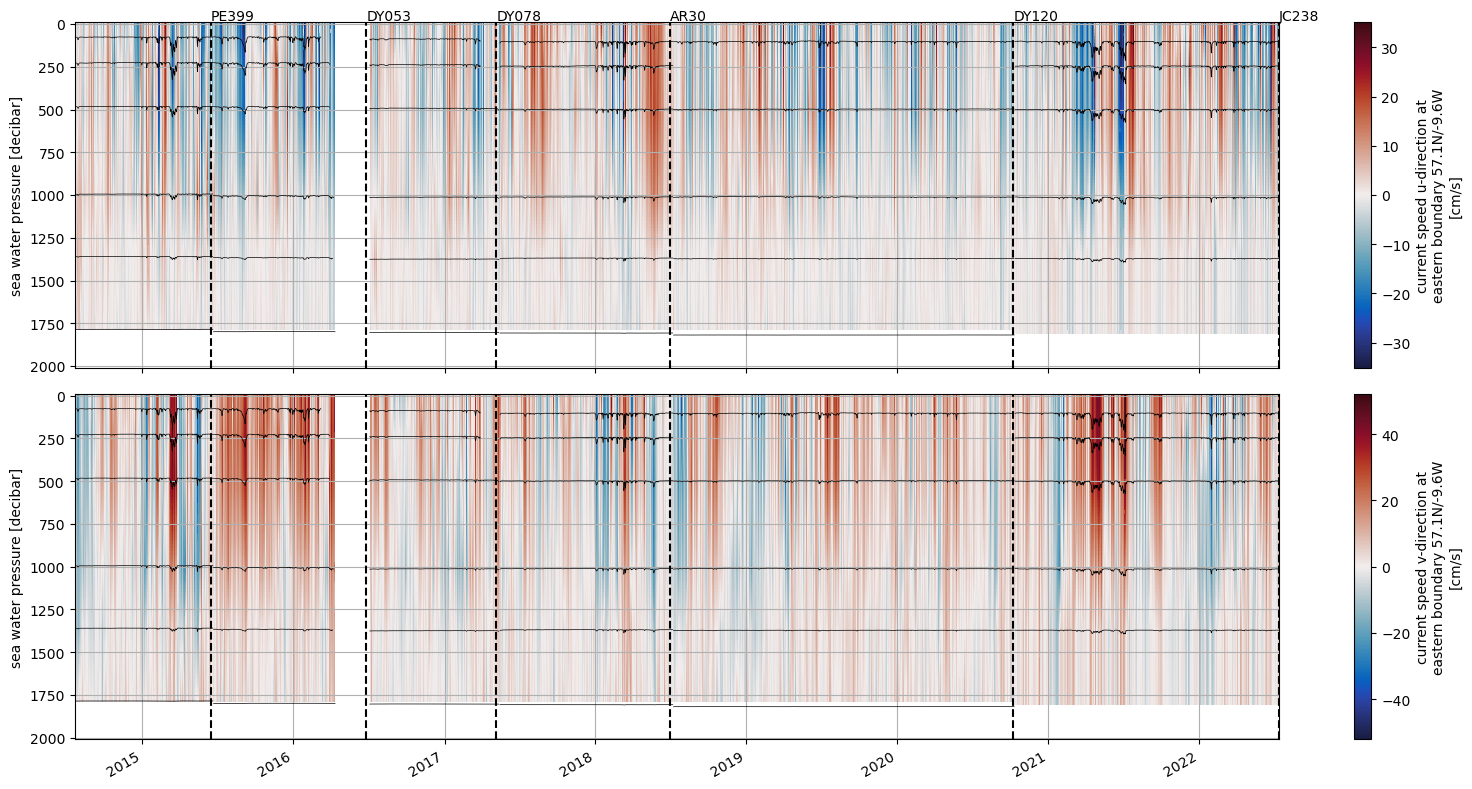

In [18]:
dim_x = 'TIME'
dim_y = 'PRES'
moor = 'EB1'
ds_RT['V_EAST'] = rtf.CM_linear_upper_values(ds_RT.V_EAST,moor,std_win,stddy_tol,nloop,dim_x,dim_y,graphics)
ds_RT['U_EAST'] = rtf.CM_linear_upper_values(ds_RT.U_EAST,moor,std_win,stddy_tol,nloop,dim_x,dim_y,graphics)

plot_moored_obs(ds_RT,moor,'velocity',ds_RT_stacked)

16338 exceeds max threshold
Loop number 1
460 spikes found
Loop number 2
330 spikes found
Loop number 3
178 spikes found
Loop number 4
81 spikes found
Loop number 5
46 spikes found
1082 exceeds max threshold
Loop number 1
12 spikes found
Loop number 2
2 spikes found
Loop number 3
0 spikes found
Loop number 4
0 spikes found
Loop number 5
0 spikes found


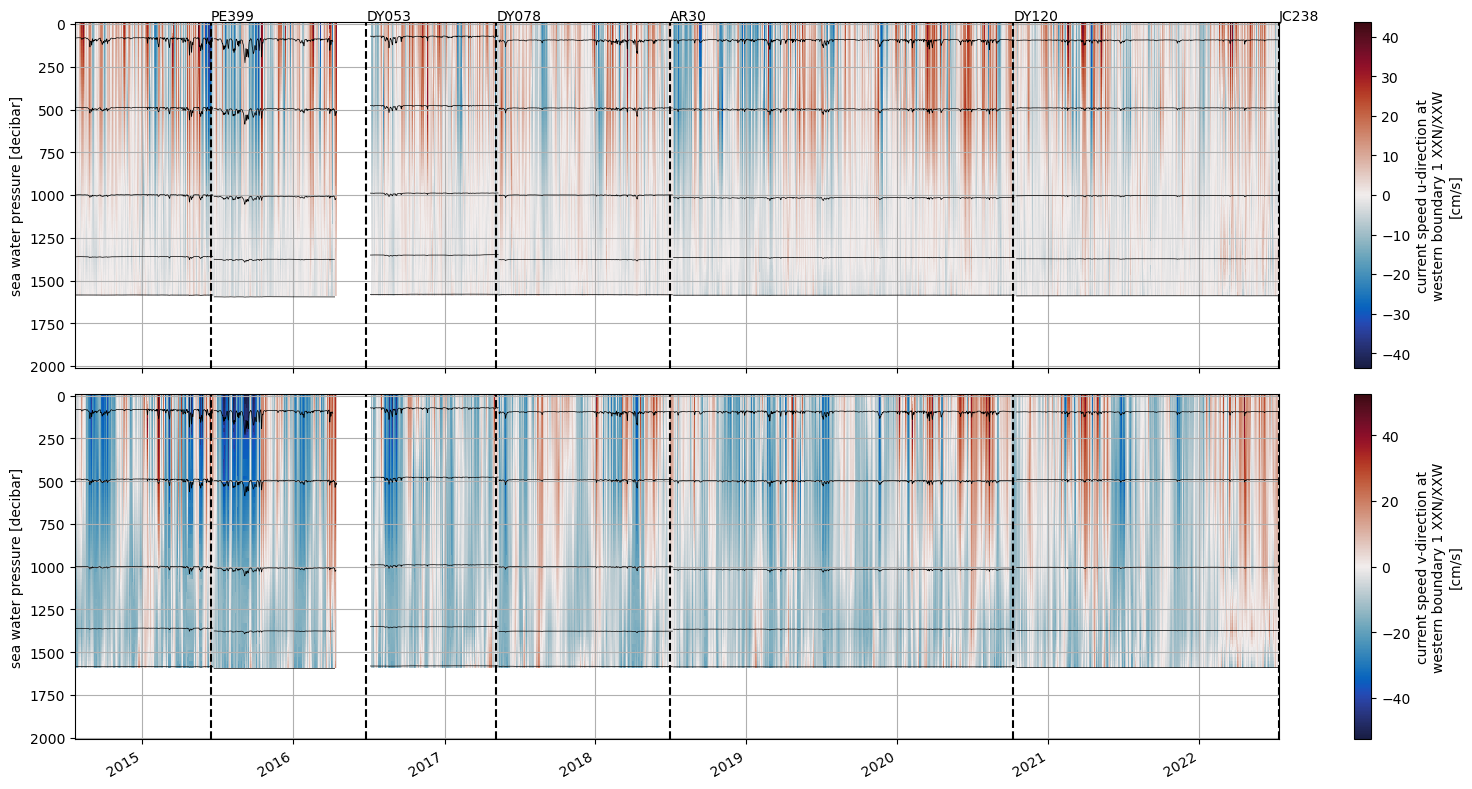

In [19]:
dim_x = 'TIME'
dim_y = 'PRES'
moor = 'WB1'
ds_RT['V_WEST_1'] = rtf.CM_linear_upper_values(ds_RT.V_WEST_1,moor,std_win,stddy_tol,nloop,dim_x,dim_y,graphics)
ds_RT['U_WEST_1'] = rtf.CM_linear_upper_values(ds_RT.U_WEST_1,moor,std_win,stddy_tol,nloop,dim_x,dim_y,graphics)

plot_moored_obs(ds_RT,moor,'velocity',ds_RT_stacked)

97 exceeds max threshold
Loop number 1
170 spikes found
Loop number 2
140 spikes found
Loop number 3
110 spikes found
Loop number 4
72 spikes found
Loop number 5
58 spikes found
98 exceeds max threshold
Loop number 1
169 spikes found
Loop number 2
133 spikes found
Loop number 3
90 spikes found
Loop number 4
58 spikes found
Loop number 5
30 spikes found


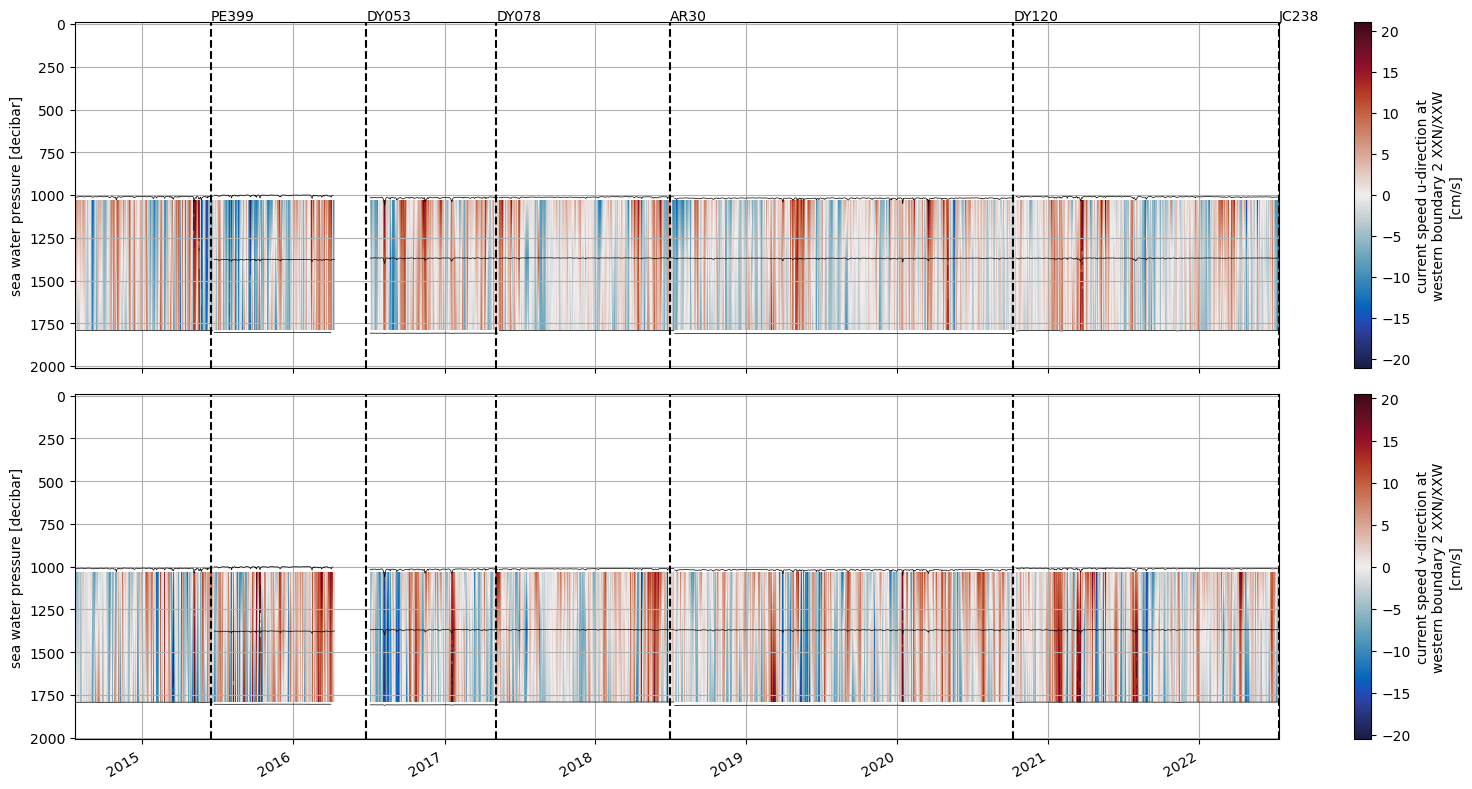

In [20]:
dim_x = 'TIME'
dim_y = 'PRES'
moor = 'WB2'
ds_RT['V_WEST_2'] = rtf.CM_linear_upper_values(ds_RT.V_WEST_2,moor,std_win,stddy_tol,nloop,dim_x,dim_y,graphics)
ds_RT['U_WEST_2'] = rtf.CM_linear_upper_values(ds_RT.U_WEST_2,moor,std_win,stddy_tol,nloop,dim_x,dim_y,graphics)

plot_moored_obs(ds_RT,moor,'velocity',ds_RT_stacked)

# Extrapolate hydro data by repeating upper values

In [21]:
def repeat_upper_values(var):
    mask = var.notnull()
    mask = mask + var.shift(PRES=-10).notnull()
    var = var.interpolate_na(
        dim='PRES',
        method="nearest",
        fill_value="extrapolate",
    ).where(mask)
    return var

In [22]:
ds_RT['TG_EAST'] = repeat_upper_values(ds_RT['TG_EAST'])
ds_RT['SG_EAST'] = repeat_upper_values(ds_RT['SG_EAST'])
ds_RT['TG_WEST'] = repeat_upper_values(ds_RT['TG_WEST'])
ds_RT['SG_WEST'] = repeat_upper_values(ds_RT['SG_WEST'])

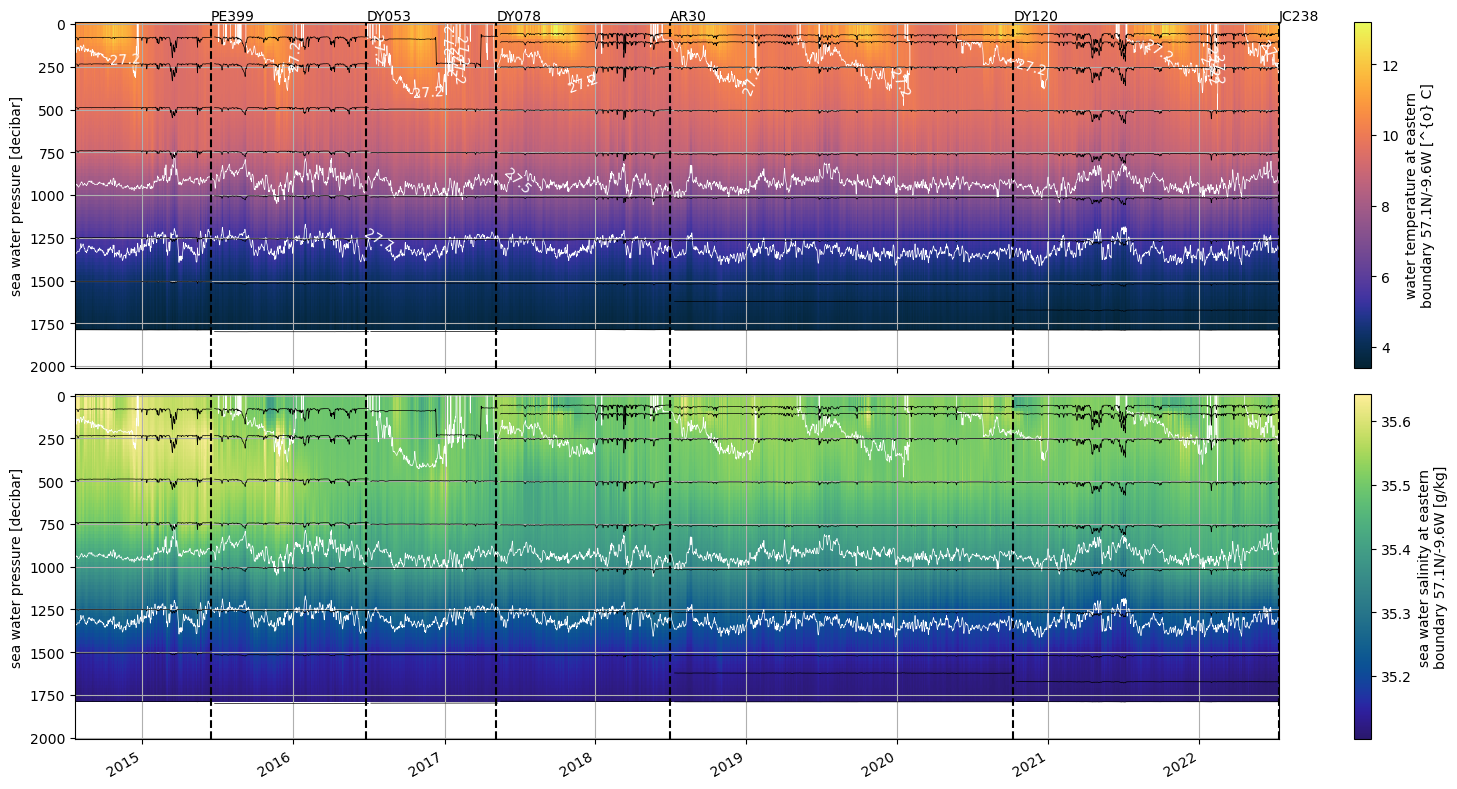

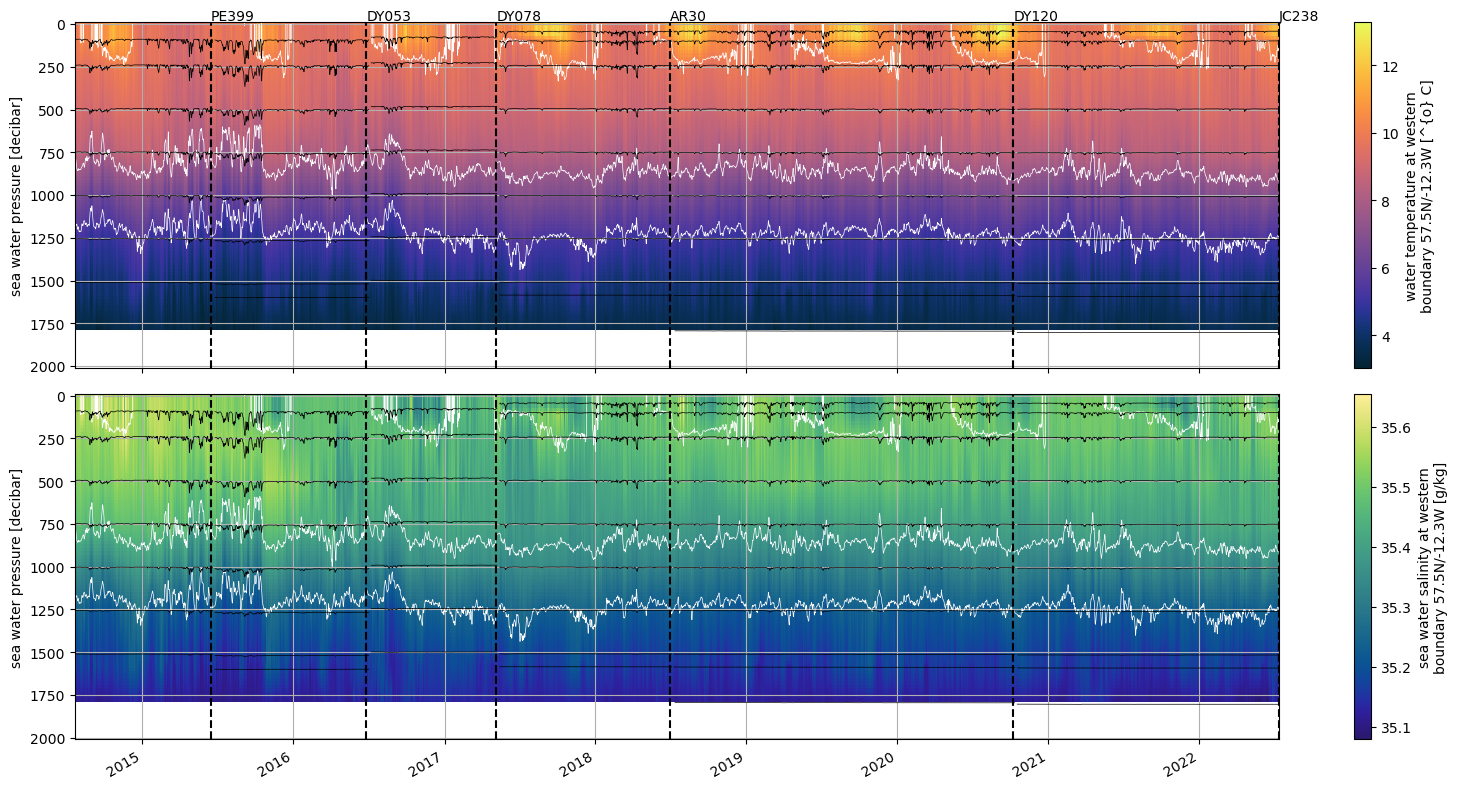

In [23]:
plot_moored_obs(ds_RT,'EB1','hydrography',ds_RT_stacked)
plot_moored_obs(ds_RT,'WB1','hydrography',ds_RT_stacked)

In [24]:
ds_RT.attrs['title']='CLASS Rockall Trough mooring data Jul 2014 to Jul 2022'
ds_RT.attrs['history']=f'Delayed time processed quality controlled Surface extrapolation done with. Surface extrapolation done with {script_name}.ipynb'
ds_RT.attrs['id']='Rockall_Trough_mooring_gridded_TSUV_201407_202207_v0.1'
ds_RT.attrs['time_coverage_start'] = f'{ds_RT.TIME.min().values}'
ds_RT.attrs['time_coverage_end'] = f'{ds_RT.TIME.max().values}'
ds_RT.attrs['date_modified'] = datetime.datetime.now().strftime("%d-%m-%YT%H:%M:%SZ")
ds_RT.attrs['contributor_name'] = 'Kristin Burmeister'
ds_RT.attrs['contributor_email'] = 'Kristin.Burmeister@sams.ac.uk'
ds_RT.to_netcdf((data_out_path/file_name_out))

# Plot for paper

In [45]:
fig = rtv.plot_moorings_paper(ds_RT,ds_RT_stacked)

fig.savefig(fig_out_path/f'RT_EB_WB_gridded_timeseries_{date_str_start[:-2]}_{date_str_end[:-2]}.png',bbox_inches='tight')